In [1]:
import ray
ray.init()
from ray import tune


2021-08-30 12:48:24,163	INFO worker.py:801 -- Connecting to existing Ray cluster at address: 172.31.107.75:6379
2021-08-30 13:43:07,074	WARNING worker.py:1189 -- The node with node id: e170ca6bacf130cd5cfa9fac56173fa8f34c45ebd1622af751841574 and ip: 172.31.28.74 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a raylet crashes unexpectedly or has lagging heartbeats.
2021-08-30 13:43:08,073	WARNING worker.py:1189 -- The node with node id: d63a4dd36a21f2cc36535646be3d69a5bf8d865fcf101efda595d9c9 and ip: 172.31.24.163 has been marked dead because the detector has missed too many heartbeats from it. This can happen when a raylet crashes unexpectedly or has lagging heartbeats.


In [2]:
ray.__version__

'1.5.2'

In [13]:
import torch
import torch.nn as nn
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import max_error
%matplotlib inline

In [4]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'tips',
 'titanic']

In [5]:
flight_data = sns.load_dataset("flights")
flight_data.head()


,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


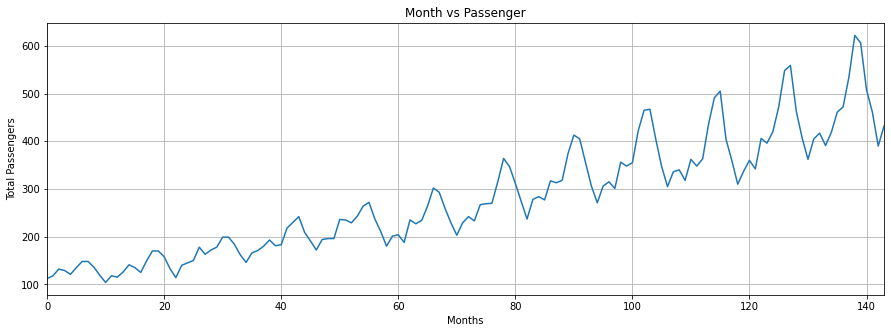

In [6]:
fig_size = plt.rcParams["figure.figsize"]
fig_size[0] = 15
fig_size[1] = 5
plt.rcParams["figure.figsize"] = fig_size
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])


In [7]:
all_data = flight_data['passengers'].values.astype(float)
test_data_size = 12
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
all_data_normalized = scaler.fit_transform(all_data .reshape(-1, 1))
train_data_normalized  = all_data_normalized[:-test_data_size]
test_data_normalized = all_data_normalized[-test_data_size:]

In [14]:
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)


In [15]:
train_window = 12
def create_inout_sequences(input_data, tw):
    inout_seq = []
    L = len(input_data)
    for i in range(L-tw):
        train_seq = input_data[i:i+tw]
        train_label = input_data[i+tw:i+tw+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq
train_inout_seq = create_inout_sequences(train_data_normalized, train_window)


In [16]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size)

        self.linear = nn.Linear(hidden_layer_size, output_size)

        self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
                            torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):
        lstm_out, self.hidden_cell = self.lstm(input_seq.view(len(input_seq) ,1, -1), self.hidden_cell)
        predictions = self.linear(lstm_out.view(len(input_seq), -1))
        return predictions[-1]

In [23]:
import time
def train(model, optimizer, loss_function, epochs):
#     cur = time.time()
    for i in range(epochs):
        for seq, labels in train_inout_seq:
            optimizer.zero_grad()
            model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
            y_pred = model(seq)
            single_loss = loss_function(y_pred, labels)
            single_loss.backward()
            optimizer.step()
#         if i%25 == 1:
#             print(f'epoch: {i:3} loss: {single_loss.item():10.8f} execution time: {time.time() - cur}')
#             cur = time.time()
    print(f'epoch: {i:3} loss: {single_loss.item():10.10f}')
def test(model, test_input, truth):
    model.eval()
    for i in range(train_window):
        seq = torch.FloatTensor(test_input[-train_window:])
        with torch.no_grad():
            model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        torch.zeros(1, 1, model.hidden_layer_size))
            test_input.append(model(seq).item())
    return max_error(test_input[train_window:],test_data_normalized)
    

#     actual_predictions = scaler.inverse_transform( ).reshape(-1, 1))
#     print(actual_predictions)

def orchestrate(config):
    
    epochs = 50
    model = LSTM()
    loss_function = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    train(model, optimizer, loss_function, epochs)
    test_inputs = train_data_normalized[-train_window:].tolist()

    error = test(model, test_inputs, test_data_normalized)
    tune.report(error = error)
    print(error)

In [24]:
search_space = {
    "lr":  tune.grid_search([0.1,0.01,0.001,0.0001]),
}

analysis = tune.run(orchestrate, config=search_space)

Trial name,status,loc,lr
orchestrate_33ed1_00000,PENDING,,0.1
orchestrate_33ed1_00001,PENDING,,0.01
orchestrate_33ed1_00002,PENDING,,0.001
orchestrate_33ed1_00003,PENDING,,0.0001


Result for orchestrate_33ed1_00001:
  date: 2021-08-30_14-50-15
  done: false
  error: 0.33125758171081543
  experiment_id: 15f49f5dce0645d0af89ee5b11f1436c
  hostname: ip-172-31-107-75
  iterations_since_restore: 1
  node_ip: 172.31.107.75
  pid: 24517
  time_since_restore: 21.583272218704224
  time_this_iter_s: 21.583272218704224
  time_total_s: 21.583272218704224
  timestamp: 1630360215
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 33ed1_00001
  


Trial name,status,loc,lr,iter,total time (s),error
orchestrate_33ed1_00000,RUNNING,,0.1,,,
orchestrate_33ed1_00001,RUNNING,172.31.107.75:24517,0.01,1,21.5833,0.331258
orchestrate_33ed1_00002,RUNNING,,0.001,,,
orchestrate_33ed1_00003,RUNNING,,0.0001,,,


Result for orchestrate_33ed1_00001:
  date: 2021-08-30_14-50-15
  done: true
  error: 0.33125758171081543
  experiment_id: 15f49f5dce0645d0af89ee5b11f1436c
  experiment_tag: 1_lr=0.01
  hostname: ip-172-31-107-75
  iterations_since_restore: 1
  node_ip: 172.31.107.75
  pid: 24517
  time_since_restore: 21.583272218704224
  time_this_iter_s: 21.583272218704224
  time_total_s: 21.583272218704224
  timestamp: 1630360215
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: 33ed1_00001
  
(pid=24517) epoch:  49 loss: 0.0018555400
(pid=24517) 0.33125758171081543
Result for orchestrate_33ed1_00000:
  date: 2021-08-30_14-50-15
  done: false
  error: 0.7671921253204346
  experiment_id: 4c1ef44c34184376b57b8eb9b36a1565
  hostname: ip-172-31-107-75
  iterations_since_restore: 1
  node_ip: 172.31.107.75
  pid: 24514
  time_since_restore: 21.36300301551819
  time_this_iter_s: 21.36300301551819
  time_total_s: 21.36300301551819
  timestamp: 1630360215
  timesteps_since_restore: 0
  traini

Trial name,status,loc,lr,iter,total time (s),error
orchestrate_33ed1_00000,TERMINATED,,0.1,1,21.363,0.767192
orchestrate_33ed1_00001,TERMINATED,,0.01,1,21.5833,0.331258
orchestrate_33ed1_00002,TERMINATED,,0.001,1,22.381,0.84147
orchestrate_33ed1_00003,TERMINATED,,0.0001,1,24.5086,0.894507


2021-08-30 14:50:18,709	INFO tune.py:550 -- Total run time: 27.71 seconds (27.53 seconds for the tuning loop).


In [30]:
print("Best config: ", analysis.get_best_config(
    metric="error", mode="min"))


Best config:  {'lr': 0.01}


In [31]:
df = analysis.results_df


In [32]:
df.head()

,error,time_this_iter_s,done,timesteps_total,episodes_total,training_iteration,experiment_id,date,timestamp,time_total_s,pid,hostname,node_ip,time_since_restore,timesteps_since_restore,iterations_since_restore,experiment_tag,config.lr
trial_id,,,,,,,,,,,,,,,,,,
33ed1_00000,0.767192,21.363003,True,None,None,1,4c1ef44c34184376b57b8eb9b36a1565,2021-08-30_14-50-15,1630360215,21.363003,24514,ip-172-31-107-75,172.31.107.75,21.363003,0,1,0_lr=0.1,0.1000
33ed1_00001,0.331258,21.583272,True,None,None,1,15f49f5dce0645d0af89ee5b11f1436c,2021-08-30_14-50-15,1630360215,21.583272,24517,ip-172-31-107-75,172.31.107.75,21.583272,0,1,1_lr=0.01,0.0100
33ed1_00002,0.841470,22.381038,True,None,None,1,2330042f452142d4b29977fc92bcf4fe,2021-08-30_14-50-16,1630360216,22.381038,24512,ip-172-31-107-75,172.31.107.75,22.381038,0,1,2_lr=0.001,0.0010
33ed1_00003,0.894507,24.508621,True,None,None,1,5cf27314fde54493a19580d5db73ddf2,2021-08-30_14-50-18,1630360218,24.508621,24515,ip-172-31-107-75,172.31.107.75,24.508621,0,1,3_lr=0.0001,0.0001


NameError: name 'actual_predictions' is not defined

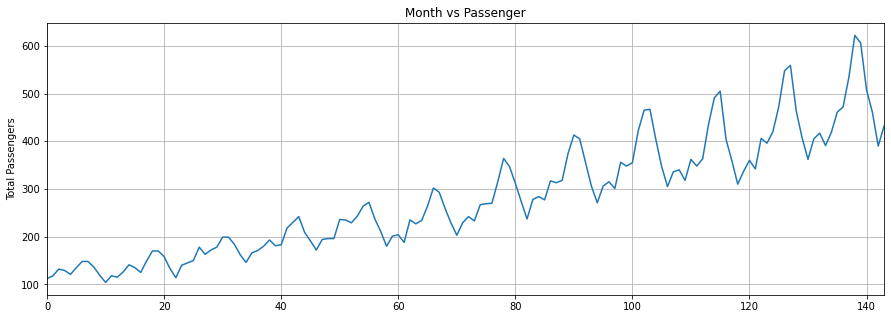

In [59]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)
plt.plot(flight_data['passengers'])
plt.plot(x,actual_predictions)
plt.show()

In [ ]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.grid(True)
plt.autoscale(axis='x', tight=True)

plt.plot(flight_data['passengers'][-train_window:])
plt.plot(x,actual_predictions)
plt.show()

In [ ]:
train_data_normalized

In [ ]:
test_inputs = train_data_normalized[-train_window:].tolist()

In [ ]:
all_data[-12:]

In [ ]:
train_data

In [40]:
test_data

array([417., 391., 419., 461., 472., 535., 622., 606., 508., 461., 390.,
       432.])

In [65]:
test_data_normalized.shape

(12, 1)